In [15]:
%%writefile practice4.cu
// Практическая работа 4: Оптимизация параллельного кода на GPU с использованием различных типов памяти

#include <iostream>              // Для работы с вводом/выводом
#include <vector>                // Работа с массивами CPU
#include <cstdlib>               // Функция rand()
#include <cuda_runtime.h>        // Основные функции CUDA
#include <chrono>                // Для измерения времени выполнения

using namespace std;             // Использование стандартного пространства имён

// Генерация массива случайных чисел
void generate_array(int *arr, int N) {            // Функция заполнения массива
    for (int i = 0; i < N; i++)                   // Цикл по всем элементам
        arr[i] = rand() % 100;                    // Заполнение случайными числами
}


// Редукция суммы: только глобальная память
__global__ void reduction_global(int *arr, int *result, int N) {

    int idx = blockIdx.x * blockDim.x + threadIdx.x;   // Глобальный индекс потока

    if (idx < N)                                      // Проверка выхода за границы
        atomicAdd(result, arr[idx]);                 // Атомарное сложение в global memory
}

// Редукция суммы: глобальная и разделяемая память
__global__ void reduction_shared(int *arr, int *result, int N) {

    __shared__ int shared[256];                 // Разделяемая память блока

    int tid = threadIdx.x;                      // Локальный индекс потока
    int idx = blockIdx.x * blockDim.x + tid;    // Глобальный индекс потока

    if (idx < N) shared[tid] = arr[idx];       // Копирование из global в shared
    else shared[tid] = 0;                       // Заполнение нулями лишних потоков

    __syncthreads();                            // Синхронизация потоков блока

    for (int stride = blockDim.x / 2; stride > 0; stride >>= 1) { // Редукция в shared
        if (tid < stride)                       // Потоки суммируют пары элементов
            shared[tid] += shared[tid + stride];
        __syncthreads();                        // Синхронизация после каждого шага
    }

    if (tid == 0)                               // Первый поток блока
        atomicAdd(result, shared[0]);           // Записывает сумму блока в global memory
}

// Пузырьковая сортировка подмассивов
__global__ void bubble_subarrays(int *arr, int N) {

    int start = blockIdx.x * blockDim.x;        // Начало подмассива блока
    int tid = threadIdx.x;                      // Локальный индекс потока
    int idx = start + tid;                      // Глобальный индекс элемента

    int local;                                 // Локальная память потока (регистр)

    if (idx < N) local = arr[idx];             // Загрузка элемента в локальную память

    __syncthreads();                           // Синхронизация потоков

    for (int i = 0; i < blockDim.x; i++) {     // Цикл пузырьковой сортировки
        if (tid < blockDim.x - 1 && idx + 1 < N) { // Проверка соседнего элемента
            if (local > arr[idx + 1]) {        // Сравнение элементов
                int tmp = local;                // Временная переменная
                local = arr[idx + 1];          // Обмен значениями
                arr[idx + 1] = tmp;            // Запись в глобальную память
            }
        }
        __syncthreads();                       // Синхронизация после каждой итерации
    }

    if (idx < N) arr[idx] = local;             // Запись отсортированного значения назад
}

// Слияние подмассивов — разделяемая память
__global__ void merge_shared(int *arr, int *temp, int N) {

    __shared__ int shared[256];                // Разделяемая память блока

    int tid = threadIdx.x;                     // Локальный индекс потока
    int idx = blockIdx.x * blockDim.x + tid;   // Глобальный индекс

    if (idx < N)
        shared[tid] = arr[idx];                // Копирование данных в shared memory

    __syncthreads();                           // Синхронизация потоков

    if (idx < N)
        temp[idx] = shared[tid];               // Запись из shared в выходной массив
}



void measure(int N, float &tGlobal, float &tShared, float &tSort) {    // Функция измерения времени

    int *h_arr = new int[N];                   // Выделение памяти под массив на CPU
    generate_array(h_arr, N);                  // Заполнение массива

    int *d_arr, *d_temp, *d_result;            // Указатели на память GPU
    cudaMalloc(&d_arr, N * sizeof(int));       // Выделение глобальной памяти GPU
    cudaMalloc(&d_temp, N * sizeof(int));      // Память под временный массив
    cudaMalloc(&d_result, sizeof(int));        // Память под сумму

    cudaMemcpy(d_arr, h_arr, N * sizeof(int), cudaMemcpyHostToDevice); // Копирование на GPU

    int zero = 0;                              // Начальное значение суммы
    cudaMemcpy(d_result, &zero, sizeof(int), cudaMemcpyHostToDevice); // Обнуление результата

    int threads = 256;                         // Количество потоков в блоке
    int blocks = (N + threads - 1) / threads;  // Количество блоков

    // Редукция глобальная
    auto start = chrono::high_resolution_clock::now();   // Начало замера
    reduction_global<<<blocks, threads>>>(d_arr, d_result, N); // Запуск ядра
    cudaDeviceSynchronize();                             // Ожидание завершения GPU
    auto end = chrono::high_resolution_clock::now();     // Конец замера
    tGlobal = chrono::duration<float>(end - start).count(); // Время выполнения

    // Редукция разделяемая
    cudaMemcpy(d_result, &zero, sizeof(int), cudaMemcpyHostToDevice); // Сброс суммы
    start = chrono::high_resolution_clock::now();                     // Начало замера
    reduction_shared<<<blocks, threads>>>(d_arr, d_result, N); // Запуск ядра shared
    cudaDeviceSynchronize();
    end = chrono::high_resolution_clock::now();                       // Конец замера
    tShared = chrono::duration<float>(end - start).count(); // Время shared редукции

    // Сортировка и слияние
    start = chrono::high_resolution_clock::now();          // Начало замера
    bubble_subarrays<<<blocks, threads>>>(d_arr, N);      // Запуск сортировки
    merge_shared<<<blocks, threads>>>(d_arr, d_temp, N); // Запуск слияния
    cudaDeviceSynchronize();
    end = chrono::high_resolution_clock::now();           // Конец замера
    tSort = chrono::duration<float>(end - start).count(); // Время сортировки + слияния

    cudaFree(d_arr);                         // Освобождение памяти GPU
    cudaFree(d_temp);
    cudaFree(d_result);
    delete[] h_arr;                          // Освобождение памяти CPU
}


int main() {                                 // Основная функция

    int sizes[3] = {10000, 100000, 1000000}; // Размеры массивов

    for (int i = 0; i < 3; i++) {            // Цикл по размерам

        float tg, ts, tso;                    // Переменные для времени
        measure(sizes[i], tg, ts, tso);      // Запуск измерений

        cout << "Размер массива: " << sizes[i] << endl;
        cout << "Редукция (Глобальная): " << tg << " сек" << endl;
        cout << "Редукция (Глобальная и Разделяемая): " << ts << " сек" << endl;
        cout << "Сортировка и слияние: " << tso << " сек" << endl << endl;
    }

    return 0;                                // Завершение программы
}



Writing practice4.cu


In [16]:
# Компиляция
!nvcc practice4.cu -o practice4

# Запуск
!./practice4

Размер массива: 10000
Редукция (Глобальная): 0.0107919 сек
Редукция (Глобальная и Разделяемая): 4.454e-06 сек
Сортировка и слияние: 2.296e-06 сек

Размер массива: 100000
Редукция (Глобальная): 5.548e-06 сек
Редукция (Глобальная и Разделяемая): 5.171e-06 сек
Сортировка и слияние: 2.63e-06 сек

Размер массива: 1000000
Редукция (Глобальная): 6.402e-06 сек
Редукция (Глобальная и Разделяемая): 5.152e-06 сек
Сортировка и слияние: 2.119e-06 сек



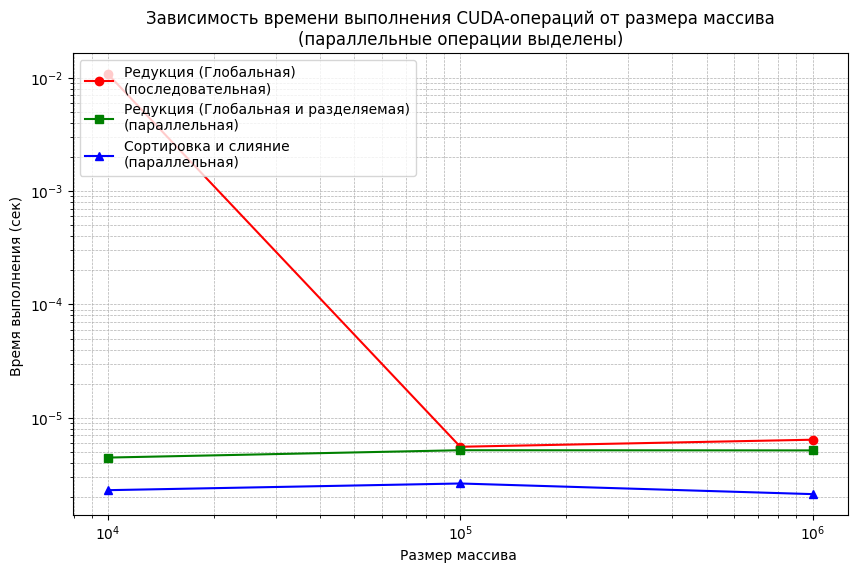

In [19]:
import matplotlib.pyplot as plt

# Размеры массивов
sizes = [10000, 100000, 1000000]

# Время выполнения (сек) — самому подставить время
time_global = [0.0107919, 5.548e-06, 6.402e-06]  # Время редукция(глобальная)
time_shared = [4.454e-06, 5.171e-06, 5.152e-06]  # Время редукция(глобальная и разделяемая)
time_sort = [2.296e-06, 2.63e-06, 2.119e-06]     # Время Сортировка и слияние

plt.figure(figsize=(10,6))

# График редукции Глобальная — последовательная/медленная
plt.plot(sizes, time_global, 'o-', color='red', label='Редукция (Глобальная)\n(последовательная)')

# График редукции Глобальная и разделяемая — параллельная
plt.plot(sizes, time_shared, 's-', color='green', label='Редукция (Глобальная и разделяемая)\n(параллельная)')

# График сортировки и слияния — параллельная
plt.plot(sizes, time_sort, '^-', color='blue', label='Сортировка и слияние\n(параллельная)')

# Логарифмические оси для наглядности
plt.xscale('log')
plt.yscale('log')

# Подписи осей и заголовок
plt.xlabel('Размер массива ')
plt.ylabel('Время выполнения (сек) ')
plt.title('Зависимость времени выполнения CUDA-операций от размера массива\n(параллельные операции выделены)')

# Сетка
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Легенда
plt.legend(loc='upper left')

# Вывод графика
plt.show()
